### check params of the swot raster data

In [16]:
import os
import xarray as xr
from glob import glob
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
from utils.swot_data_mask import swot_raster_mask
from utils.functions import swot_raster_reproj


In [17]:
dir_raster = 'data/dianchi_lake/raster'
path_lake_vec = 'data/dianchi_lake/dianchi_vector.gpkg'


In [18]:
## read vector file of the lake.
lake_gpd = gpd.read_file(path_lake_vec)
lake_gpd


,Name,geometry
0,dianchi,"POLYGON Z ((102.66614 24.83805 0.00000, 102.65..."


In [19]:
## Check original .nc raster file.
paths_file = [os.path.join(dir_raster, file) for file in os.listdir(dir_raster) if 'Raster_' in file and 'wse' not in file]
paths_file = sorted(paths_file)
print(len(paths_file))


9


In [21]:
file_id = 3
raster_nc = xr.open_dataset(paths_file[file_id], decode_times=False)
raster_nc


<xarray.Dataset>
Dimensions:                  (x: 1501, y: 1500)
Coordinates:
  * x                        (x) float64 1.961e+05 1.962e+05 ... 3.461e+05
  * y                        (y) float64 2.645e+06 2.645e+06 ... 2.795e+06
Data variables: (12/39)
    crs                      object ...
    longitude                (y, x) float64 ...
    latitude                 (y, x) float64 ...
    wse                      (y, x) float32 ...
    wse_qual                 (y, x) float32 ...
    wse_qual_bitwise         (y, x) float64 ...
    ...                       ...
    load_tide_fes            (y, x) float32 ...
    load_tide_got            (y, x) float32 ...
    pole_tide                (y, x) float32 ...
    model_dry_tropo_cor      (y, x) float32 ...
    model_wet_tropo_cor      (y, x) float32 ...
    iono_cor_gim_ka          (y, x) float32 ...
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-03-12T12:53:29Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         196100.0
    x_max:                         346100.0
    y_min:                         2644900.0
    y_max:                         2794800.0
    institution:                   CNES
    product_version:               01

In [37]:
raster_epsg = '326' + str(raster_nc.attrs['utm_zone_num'])
raster_wgs84_nc = swot_raster_reproj(raster_nc, epsg_from=raster_epsg, epsg_to='4326')
raster_wgs84_nc



<xarray.Dataset>
Dimensions:                  (x: 1590, y: 1453)
Coordinates:
  * x                        (x) float64 102.0 102.0 102.0 ... 103.5 103.5 103.5
  * y                        (y) float64 25.26 25.26 25.26 ... 23.89 23.89 23.89
    crs                      int64 0
Data variables: (12/38)
    longitude                (y, x) float64 nan nan nan nan ... nan nan nan nan
    latitude                 (y, x) float64 nan nan nan nan ... nan nan nan nan
    wse                      (y, x) float32 nan nan nan nan ... nan nan nan nan
    wse_qual                 (y, x) float32 nan nan nan nan ... nan nan nan nan
    wse_qual_bitwise         (y, x) float64 nan nan nan nan ... nan nan nan nan
    wse_uncert               (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    load_tide_fes            (y, x) float32 nan nan nan nan ... nan nan nan nan
    load_tide_got            (y, x) float32 nan nan nan nan ... nan nan nan nan
    pole_tide                (y, x) float32 nan nan nan nan ... nan nan nan nan
    model_dry_tropo_cor      (y, x) float32 nan nan nan nan ... nan nan nan nan
    model_wet_tropo_cor      (y, x) float32 nan nan nan nan ... nan nan nan nan
    iono_cor_gim_ka          (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-03-12T12:53:29Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         196100.0
    x_max:                         346100.0
    y_min:                         2644900.0
    y_max:                         2794800.0
    institution:                   CNES
    product_version:               01

In [38]:
# Calculate the extent of the raster_wgs84_nc using its coordinates
xmin, xmax = raster_wgs84_nc.x.min().item(), raster_wgs84_nc.x.max().item()
ymin, ymax = raster_wgs84_nc.y.min().item(), raster_wgs84_nc.y.max().item()
raster_extent = [xmin, xmax, ymin, ymax]
raster_extent


[101.98339928272442, 103.48838533184787, 23.88643554504413, 25.261665087729625]

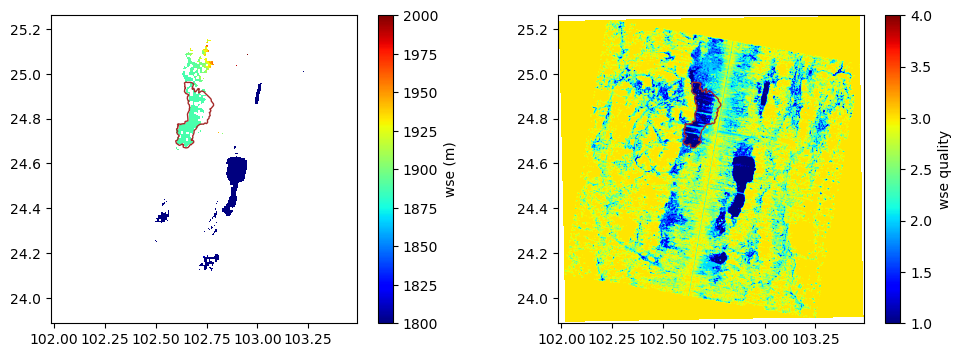

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
# ax1
im1 = ax[0].imshow(raster_wgs84_nc.wse.values, 
                   cmap='jet', extent=raster_extent, vmax=2000, vmin=1800)
lake_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)

# ax2
im2 = ax[1].imshow(raster_wgs84_nc.wse_qual.values, 
                   cmap='jet', extent=raster_extent, vmin=1, vmax=4)
lake_gpd.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
fig.colorbar(im1, ax=ax[0]).set_label('wse (m)')
fig.colorbar(im2, ax=ax[1]).set_label('wse quality')


In [40]:
raster_wgs84_clipped = swot_raster_mask(raster_wgs84_nc, 
                                vars_sel=None, region_gpd=lake_gpd, path_masked=None)


In [41]:
# raster_wgs84_clipped = raster_wgs84_nc.rio.clip(lake_gpd.geometry.values, lake_gpd.crs, drop=True)
raster_clipped_extent = [raster_wgs84_clipped.x.min().item(), raster_wgs84_clipped.x.max().item(), 
                          raster_wgs84_clipped.y.min().item(), raster_wgs84_clipped.y.max().item()]
raster_clipped_extent


[102.59903234246654, 102.78372226038918, 24.66971022259296, 24.96237270791653]

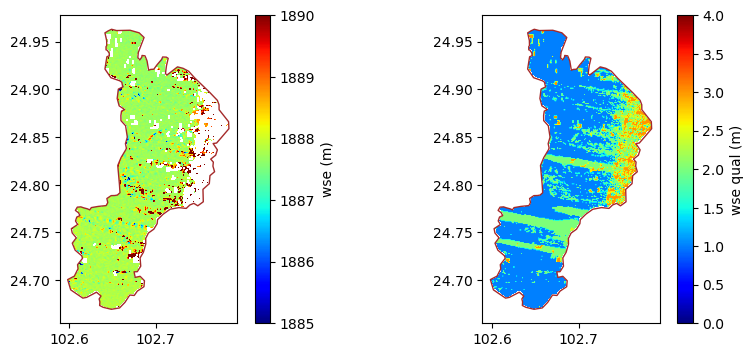

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
# ax1
im1 = ax[0].imshow(raster_wgs84_clipped.wse.values, 
                   cmap='jet', extent=raster_clipped_extent, vmin=1885, vmax=1890)
lake_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)

# ax2
im2 = ax[1].imshow(raster_wgs84_clipped.wse_qual.values, 
                   cmap='jet', extent=raster_clipped_extent, vmin=0, vmax=4)
lake_gpd.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
fig.colorbar(im1, ax=ax[0]).set_label('wse (m)')
fig.colorbar(im2, ax=ax[1]).set_label('wse qual (m)')
